# ReinforcementLearning.jl | 迷路問題

以下のような迷路問題を解く

```
┌--------------┐
| S0   S1   S2 |
|     ----┐    |
| S3   S4 | S5 |
|         └----|
| S6 | S7   S8 |
└--------------┘
```

- エージェントは S0 をスタート地点として、ゴール地点である S8 を目指す
- 報酬は S8 にたどり着いたステップ数が少ないほど高いものとする
- 壁のある方向には動けないとする

In [1]:
using ReinforcementLearning

"""
    enum MazeAction (
        UP = 1, RIGHT, DOWN, LEFT
    )

エージェントがとれる行動: 上、右、下、左に移動する

- ReinforcementLearning.jl では行動は 1 から始まる数値で表す必要がある
"""
@enum MazeAction UP=1 RIGHT DOWN LEFT

"""
    enum MazeState (
        S0 = 1, S1, S2, S3, S4, S5, S6, S7, S8
    )

エージェントのいる位置＝状態: S0 .. S8

- ReinforcementLearning.jl では行動は 1 から始まる数値で表す必要がある
"""
@enum MazeState S0=1 S1 S2 S3 S4 S5 S6 S7 S8

"""
    mutable struct MazeEnv <: AbstractEnv

迷路問題Env

- `agent_pos::Int`: エージェントの現在位置 (=状態)
- `state_action_history::Vector{NamedTuple}`: エージェントの行動記録
    - `state_action_history[n].state`: エージェントが辿った状態
    - `state_action_history[n].action`: エージェントがとった行動
- `reward::Union{Nothing, Number}`: ゴール地点に到達したときにステップ数の逆数の報酬を与える
"""
Base.@kwdef mutable struct MazeEnv <: AbstractEnv
    agent_pos::Int = Int(S0)
    state_action_history::Vector{NamedTuple} = Vector{NamedTuple}()
    reward::Union{Nothing, Number} = nothing
end

"行動空間: (1 = 上移動, 2 = 右移動, 3 = 下移動, 4 = 左移動)"
RLBase.action_space(env::MazeEnv) = Int.(instances(MazeAction))

"即時報酬はないため、env.reward === nothing のときの報酬は 0"
RLBase.reward(env::MazeEnv) = isnothing(env.reward) ? 0 : env.reward

"状態空間: (S0, S1, ..., S8)"
RLBase.state_space(env::MazeEnv) = Int.(instances(MazeState))

"状態 = エージェントの現在位置"
RLBase.state(env::MazeEnv) = env.agent_pos

"終了条件: 報酬を得たら（ゴールしたら）終了"
RLBase.is_terminated(env::MazeEnv) = !isnothing(env.reward)

"環境リセット関数"
RLBase.reset!(env::MazeEnv) = begin
    env.agent_pos = Int(S0)
    state_action_history = Vector{NamedTuple}()
    env.reward = nothing
end

"通行可能な方向への移動か判定する関数"
can_move(state::Int, action::Int) = begin
    state <= 3 && action === Int(UP) && return false
    state > 6 && action === Int(DOWN) && return false
    state % 3 === 1 && action === Int(LEFT) && return false
    state % 3 === 0 && action === Int(RIGHT) && return false
    true
end

"1ステップの状態変化を定義する関数"
(env::MazeEnv)(action::Int) = begin
    # エージェント移動記録保存
    push!(env.state_action_history, (state = env.agent_pos, action = action))

    # 通行禁止（壁）の方向に移動しようとした場合は、報酬を -1 にする
    if !can_move(env.agent_pos, action)
        env.reward = -1
        return
    end

    # 移動
    state_map = Dict(
        Int(UP)    => -3,
        Int(RIGHT) => +1,
        Int(DOWN)  => +3,
        Int(LEFT)  => -1,
    )
    env.agent_pos += state_map[action]

    # ゴールしたとき: 移動回数が少ないほど高い報酬を与える
    if env.agent_pos === Int(S8)
        push!(env.state_action_history, (state = env.agent_pos, action = NaN))
        env.reward = 100 / length(env.state_action_history)
    end
end

MazeEnv

In [2]:
env = MazeEnv()

# MazeEnv

## Traits

| Trait Type        |                  Value |
|:----------------- | ----------------------:|
| NumAgentStyle     |          SingleAgent() |
| DynamicStyle      |           Sequential() |
| InformationStyle  | ImperfectInformation() |
| ChanceStyle       |           Stochastic() |
| RewardStyle       |           StepReward() |
| UtilityStyle      |           GeneralSum() |
| ActionStyle       |     MinimalActionSet() |
| StateStyle        |     Observation{Any}() |
| DefaultStateStyle |     Observation{Any}() |

## Is Environment Terminated?

No

## State Space

`(1, 2, 3, 4, 5, 6, 7, 8, 9)`

## Action Space

`(1, 2, 3, 4)`

## Current State

```
1
```


In [3]:
# 環境が適切にセットアップされているかテスト
RLBase.test_runnable!(env)

Test Summary:              | Pass  Total
random policy with MazeEnv | 2000   2000


Test.DefaultTestSet("random policy with MazeEnv", Any[], 2000, false, false)

In [4]:
# 動作確認用Hook
# hook = DoEveryNEpisode(n = 1) do t, policy, env
#     display((t = t, env = env))
# end

# 各エピソードごとの報酬和取得Hook
hook = TotalRewardPerEpisode()

# ランダム行動選択ポリシー (RandomPolicy) で 1000 回ゲームを実行
run(
    RandomPolicy(action_space(env)),
    env,
    StopAfterEpisode(1_000),
    hook
)

            ⠀⠀⠀⠀⠀⠀⠀⠀⠀Total reward per episode⠀⠀⠀⠀⠀⠀⠀⠀⠀ 
            ┌────────────────────────────────────────┐ 
          1 │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
            │⠀⡀⡀⣀⣀⣀⠀⡀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀│ 
   Score    │⢼⡧⡧⣿⣿⣿⢼⣿⢼⠤⢴⣿⣿⠤⢼⢼⠤⢼⡧⡧⠤⡧⡧⡧⢴⣷⣿⡧⠤⡦⠤⠤⠤⢴⠤⣶⢴⡦⡦⣶│ 
            │⢸⡇⡇⣿⣿⣿⢸⣿⢸⠀⢸⣿⣿⠀⢸⢸⠀⢸⡇⡇⠀⡇⡇⡇⢸⣿⣿⡇⠀⡇⠀⠀⠀⢸⠀⣿⢸⡇⡇⣿│ 
            │⢸⡇⡇⣿⣿⣿⢸⣿⢸⠀⢸⣿⣿⠀⢸⢸⠀⢸⡇⡇⠀⡇⡇⡇⢸⣿⣿⡇⠀⡇⠀⠀⠀⢸⠀⣿⢸⡇⡇⣿│ 
            │⢸⡇⡇⣿⣿⣿⢸⣿⢸⠀⢸⣿⣿⠀⢸⢸⠀⢸⡇⡇⠀⡇⡇⡇⢸⣿⣿⡇⠀⡇⠀⠀⠀⢸⠀⣿⢸⡇⡇⣿│ 
            │⢸⡇⡇⣿⣿⣿⢸⣿⢸⠀⢸⣿⣿⠀⢸⣾⠀⣾⡇⡇⠀⡇⡇⡇⢸⣿⣿⡇⠀⡇⠀⠀⠀⢸⠀⣿⢸⡇⡇⣿│ 
            │⢸⡇⡇⣿⣿⣿⢸⣿⢸⠀⢸⣿⣿⠀⢸⣿⠀⣿⡇⡇⠀⡇⡇⡇⢸⣿⣿⡇⠀⡇⠀⠀⠀⢸⠀⣿⢸⡇⡇⣿│ 
            │⢸⡇⡇⣿⣿⣿⢸⣿⢸⠀⢸⣿⣿⠀⢸⣿⠀⣿⡇⡇⠀⡇⡇⡇⢸⣿⣿⡇⠀⡇⠀⠀⠀⢸⠀⣿⢸⡇⡇⣿│ 
         -1 │⣸⣇⣇⣿⣿⣿⣸⣿⣸⣀⣸⣿⣿⣀⣸⣿⣀⣿⣇⣇⣀⣇⣇⣇⣸⣿⣿⣇⣀⣇⣀⣀⣀⣸⣀⣿⣸⣇⣇⣿│ 
            └───────────────────────────────────

TotalRewardPerEpisode([-1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0, -1.0  …  -1.0, -1.0, 0.02717391304347826, -1.0, -1.0, -1.0, 0.027107617240444564, -1.0, -1.0, -1.0], 0.0, true)

In [5]:
using Flux: InvDecay

# Q学習用 Policy
p = QBasedPolicy(;
    learner = MonteCarloLearner(;
        approximator = TabularQApproximator(;
            n_state = length(state_space(env)),
            n_action = length(action_space(env)),
            opt = InvDecay(1.0)
        )
    ),
    explorer = EpsilonGreedyExplorer(0.5)
)

# エピソード 10,000 回ごとに、そのエピソードで得た報酬と行動履歴を記録する
records = Vector{NamedTuple}()
hook = DoEveryNEpisode(n = 10_000) do t, policy, env
    push!(records, (reward = env.reward, state_action_history = env.state_action_history))
end

# Q学習実行
run(
    Agent(
        policy = p,
        # VectorSARTTrajectory: アクション, 報酬, 状態を保存する
        trajectory = VectorSARTTrajectory()
    ),
    env,
    StopAfterEpisode(10_00_000),
    hook
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


DoEveryNEpisode{PostEpisodeStage, var"#2#3"}(var"#2#3"(), 10000, 1000000)

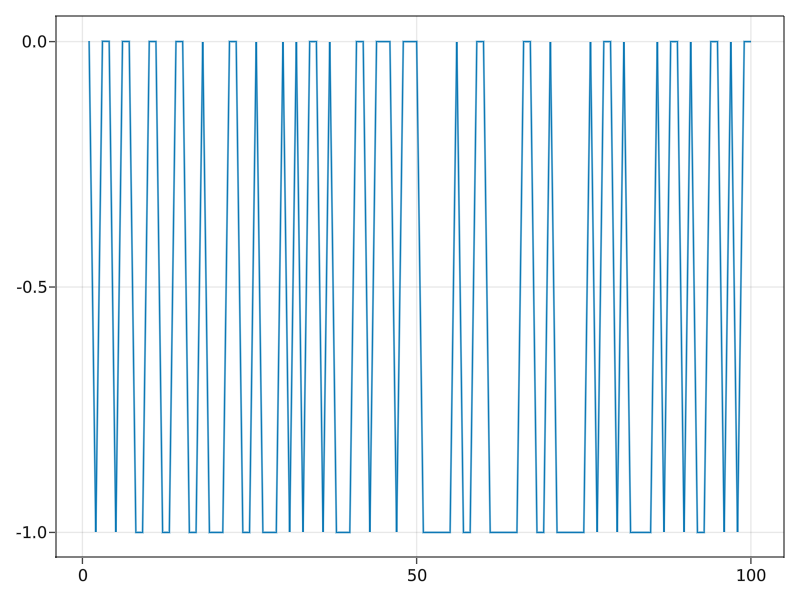

In [6]:
using GLMakie

# 学習曲線 (報酬和) をプロット
lines(getproperty.(records, :reward))

In [7]:
# 学習最後でのゴールまでのステップ数
length(records[end].state_action_history)

4327204

どこが通行禁止か分からない状態で学習しようとしても上手く学習できず、最短経路の探索以前にまともに徘徊することもできない

そのため、状態空間に壁のある方向の情報も与えてあげる必要がある

In [1]:
using ReinforcementLearning
using Flux: InvDecay

@enum MazeAction UP=1 RIGHT DOWN LEFT
@enum MazeState S0=1 S1 S2 S3 S4 S5 S6 S7 S8

"""
迷路の通行可能情報

- `Tuple(上移動, 右移動, 下移動, 左移動)`
    - 0: 通行不可（壁）
    - 1: 通行可能

```
┌--------------┐
| S0   S1   S2 |
|     ----┐    |
| S3   S4 | S5 |
|         └----|
| S6 | S7   S8 |
└--------------┘
```
"""
maze_data = [
    (0, 1, 1, 0), (0, 1, 0, 1), (0, 0, 1, 1),
    (1, 1, 1, 0), (0, 0, 1, 1), (1, 0, 0, 0),
    (1, 0, 0, 0), (1, 1, 0, 0), (0, 0, 0, 1),
]

Base.Base.@kwdef mutable struct MazeEnv2 <: AbstractEnv
    agent_pos::Int = Int(S0)
    state_action_history::Vector{NamedTuple} = Vector{NamedTuple}()
    reward::Union{Nothing, Number} = nothing
end

RLBase.action_space(env::MazeEnv2) = Int.(instances(MazeAction))

RLBase.reward(env::MazeEnv2) = isnothing(env.reward) ? 0 : env.reward

"状態空間 = 迷路情報"
RLBase.state_space(env::MazeEnv2) = maze_data

RLBase.state(env::MazeEnv2) = env.agent_pos

RLBase.is_terminated(env::MazeEnv2) = !isnothing(env.reward)

RLBase.reset!(env::MazeEnv2) = begin
    env.agent_pos = Int(S0)
    state_action_history = Vector{NamedTuple}()
    env.reward = nothing
end

can_move(state::Int, action::Int) = begin
    state <= 3 && action === Int(UP) && return false
    state > 6 && action === Int(DOWN) && return false
    state % 3 === 1 && action === Int(LEFT) && return false
    state % 3 === 0 && action === Int(RIGHT) && return false
    true
end

(env::MazeEnv2)(action::Int) = begin
    # エージェント移動記録保存
    push!(env.state_action_history, (state = env.agent_pos, action = action))

    # 通行禁止（壁）の方向に移動しようとした場合は、報酬を -1 にする
    if !can_move(env.agent_pos, action)
        env.reward = -1
        return
    end

    # 移動
    state_map = Dict(
        Int(UP)    => -3,
        Int(RIGHT) => +1,
        Int(DOWN)  => +3,
        Int(LEFT)  => -1,
    )
    env.agent_pos += state_map[action]

    # ゴールしたとき: 移動回数が少ないほど高い報酬を与える
    if env.agent_pos === Int(S8)
        push!(env.state_action_history, (state = env.agent_pos, action = NaN))
        env.reward = 100 / length(env.state_action_history)
    end
end

env = MazeEnv2()

# Q学習用 Policy
p = QBasedPolicy(;
    learner = MonteCarloLearner(;
        approximator = TabularQApproximator(;
            n_state = length(state_space(env)),
            n_action = length(action_space(env)),
            opt = InvDecay(1.0)
        )
    ),
    explorer = EpsilonGreedyExplorer(0.5)
)

# エピソード 10,000 回ごとに、そのエピソードで得た報酬と行動履歴を記録する
records = Vector{NamedTuple}()
hook = DoEveryNEpisode(n = 10_000) do t, policy, env
    push!(records, (reward = env.reward, state_action_history = env.state_action_history))
end

# Q学習実行
run(
    Agent(
        policy = p,
        # VectorSARTTrajectory: アクション, 報酬, 状態を保存する
        trajectory = VectorSARTTrajectory()
    ),
    env,
    StopAfterEpisode(10_00_000),
    hook
)

Progress: 100%|█████████████████████████████████████████| Time: 0:00:15


DoEveryNEpisode{PostEpisodeStage, var"#2#3"}(var"#2#3"(), 10000, 1000000)

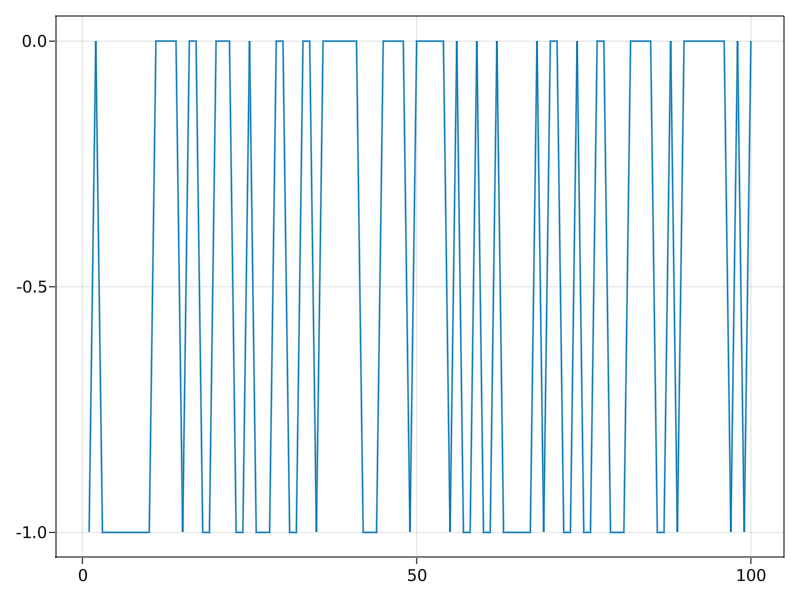

In [2]:
using GLMakie

# 学習曲線 (報酬和) をプロット
lines(getproperty.(records, :reward))

In [3]:
# 学習最後でのゴールまでのステップ数
length(records[end].state_action_history)

4322683

上手くいかない